# Importing packages

In [1]:
import numpy as np
import sys
sys.path.insert(0, "../src/")
import jax.numpy as jnp
import oracle
from data_processing import download_and_process_data
from compression_operator import Top_k
import algorithms
from copy import deepcopy
from matplotlib import pyplot as plt
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.ticker as tck

# Phishing

## Download and modify the dataset

In [3]:
num_clients = 20

In [4]:
lambda_ = 0.1

In [5]:
dataset_name = 'phishing'

In [6]:
X, y, data = download_and_process_data(dataset_name, num_clients)

Dataset is downloaded.
Data is evenly divided between 20 clients


In [7]:
d = X.shape[1]

## Create oracles

In [8]:
oracle_container = oracle.NoncvxLogRegContainer(data, lambda_)
L = oracle_container.compute_smoothness()
L_tilde = oracle_container.compute_distributed_smoothness()
print('Oracle used is {}. Smoothness constant (L) is {}. Distributed \
smoothness (L_tilde) is {}.'.format(oracle_container.__class__.__name__, L,
                                    L_tilde))

Oracle used is NoncvxLogRegContainer. Smoothness constant (L) is 0.36256536797623107. Distributed smoothness (L_tilde) is 0.36609956525744064.


# Run algorithms

In [65]:
stepsize_scales = 2 ** np.arange(0, 14, 2)

In [66]:
stepsize_scales

array([   1,    4,   16,   64,  256, 1024, 4096])

In [11]:
x_0 = jnp.zeros(d)

In [84]:
max_comm = 10000

In [85]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 10)

In [86]:
zetas

array([3.90625000e-03, 1.33944372e-02, 4.59292029e-02, 1.57490131e-01,
       5.40029869e-01, 1.85174942e+00, 6.34960421e+00, 2.17726400e+01,
       7.46578585e+01, 2.56000000e+02])

In [60]:
zetas = np.insert(zetas, 0, 0)

In [61]:
zetas

array([0.00000000e+00, 3.90625000e-03, 8.83883476e-02, 2.00000000e+00,
       4.52548340e+01, 1.02400000e+03])

In [62]:
ks = [1, int(d / 4), int(d/2), d]

In [63]:
time_limit = 180

### EF21

In [19]:
histories = dict()

In [20]:
comm = Top_k(d)
comm.compress(x_0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
adaptive=True
histories = {}
for k in ks:
    if adaptive:
        c_op = Top_k(1)
    else:
        c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    for zeta in zetas:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
            max(zeta, beta) / theta))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm, compressors = algorithms.CLAG(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    stepsize,
                                                    zeta,
                                                    max_comm,
                                                    time_limit,
                                                    adaptive=adaptive)
            print('')
#             if history[-1] < history_best[-1]:
#                 history_best = deepcopy(history)
#                 history_comm_best = deepcopy(history_comm)
#                 best_scale = stepsize_scale
            histories[(k, zeta, stepsize_scale)] = (history_comm, history, stepsize_scale, compressors)
        with open('../results/histories_{}_{}5.pickle'.format(dataset_name, adaptive), 'wb') as file:
            pickle.dump(histories, file)

1-0.00390625-1
Currently communicated 10880 float numbers
1-0.00390625-4
Currently communicated 10880 float numbers
1-0.00390625-16
Currently communicated 10880 float numbers
1-0.00390625-64
Currently communicated 10880 float numbers
1-0.00390625-256
Currently communicated 10880 float numbers
1-0.00390625-1024
Currently communicated 10880 float numbers
1-0.00390625-4096
Currently communicated 10880 float numbers
1-0.013394437232079259-1
Currently communicated 10880 float numbers
1-0.013394437232079259-4
Currently communicated 10880 float numbers
1-0.013394437232079259-16
Currently communicated 10880 float numbers
1-0.013394437232079259-64
Currently communicated 10880 float numbers
1-0.013394437232079259-256
Currently communicated 10880 float numbers
1-0.013394437232079259-1024
Currently communicated 10880 float numbers
1-0.013394437232079259-4096
Currently communicated 10880 float numbers
1-0.04592920288361246-1
Currently communicated 10880 float numbers
1-0.04592920288361246-4
Current

In [ ]:
with open('../results/histories_phishing.pickle', 'rb') as file:
    histories_2 = pickle.load(file)

In [ ]:
histories_full = {**histories, **histories_2}

In [ ]:
with open('../results/histories_phishing.pickle', 'wb') as file:
    pickle.dump(histories_full, file)

In [ ]:
histories = deepcopy(histories_full)

# Plots

In [50]:
with open('../results/histories_{}_2.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)

In [51]:
float_bits = 32

In [52]:
bit_scale = 1000

In [53]:
histories_2 = {}
for k, v in histories.items():
    comm, norm, scale = v
    comm_ = [x * float_bits / (num_clients * bit_scale) for x in comm]
    norm_ = [x ** 2 for x in norm]
    histories_2[k] = (comm_, norm_, scale)

In [54]:
ks = [1, int(d / 4), int(d/2), d]

In [55]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 3)
zetas = np.insert(zetas, 0, 0)

In [26]:
size = 40
marker_size = 30
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 4
# plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = size  # 40
plt.rcParams['ytick.labelsize'] = size  # 40
plt.rcParams['legend.fontsize'] = 30  # 30
plt.rcParams['axes.titlesize'] = size  # 40
plt.rcParams['axes.labelsize'] = size  # 40
plt.rcParams["figure.figsize"] = [50, 20]

1


30


61


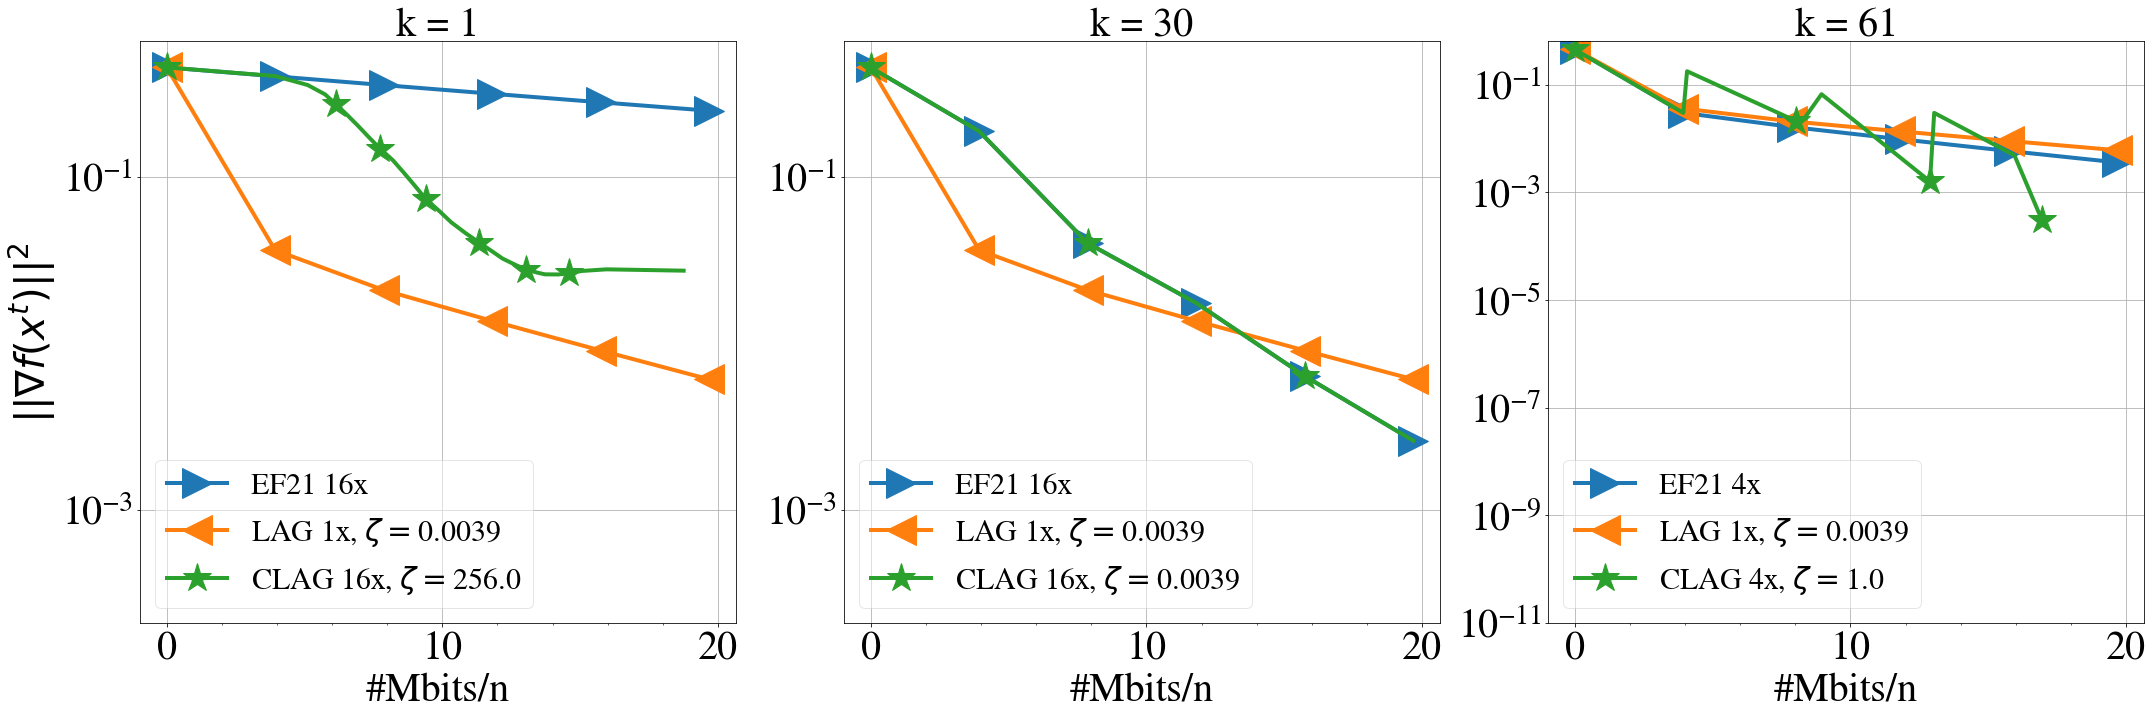

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks) - 1, figsize=(30, 10),
                       sharey=True)
# LAG
best_zeta_lag = zetas[1]
for zeta in zetas[2:]:
    if histories_2[(d, zeta)][1][-1] < histories_2[(d, best_zeta_lag)][1][-1]:
        best_zeta = zeta
comm_lag, norm_lag, scale_lag = histories_2[(d, best_zeta_lag)]
for k_id, k in enumerate(ks[:-1]):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21 = histories_2[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21 {}x'.format(scale_ef21),
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG {}x, $\zeta=${}'.format(scale_lag, round(best_zeta_lag, 4)),
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    best_zeta = zetas[1]
    for zeta in zetas[2:]:
        if histories_2[(k, zeta)][1][-1] < histories_2[(k, best_zeta)][1][-1]:
            best_zeta = zeta
    comm_clag, norm_clag, scale_clag = histories_2[(k, best_zeta)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG {}x, $\zeta=${}'.format(
                    scale_clag, round(best_zeta, 4)),
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    fig.tight_layout()
    fig.savefig('../plots/plot_{}.pdf'.format(dataset_name))

In [113]:
with open('../results/histories_{}_True3.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)
with open('../results/histories_{}_False.pickle'.format(dataset_name), 'rb') as file:
    histories_clag = pickle.load(file)

KeyError: (68, 0.1574901312368592)

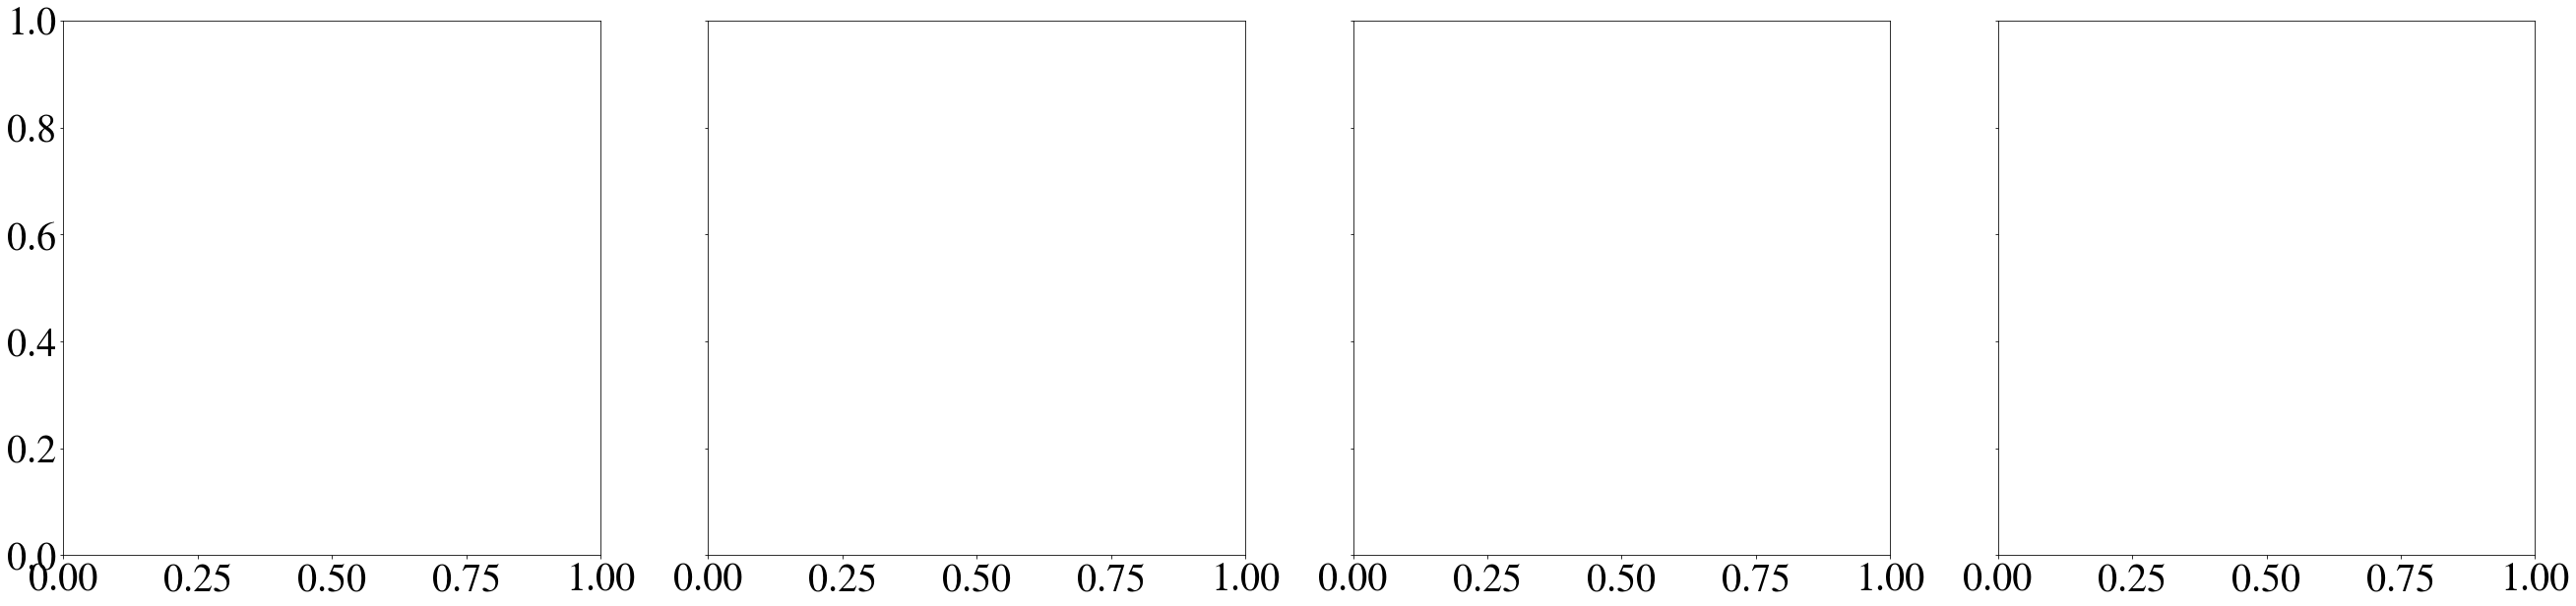

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(45, 10),
                       sharey=True)

z = zetas[3]
comm_lag, norm_lag, scale_lag = histories_clag[(d, z)]

for k_id, k in enumerate(ks):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21 = histories_clag[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21',
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG',
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    comm_clag, norm_clag, scale_clag = histories_clag[(k, z)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG',
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    comm_alag, norm_alag, scale_alag = histories[(k, z)]
    ax[k_id].plot(comm_alag,
              norm_alag,
              label='aCLAG',
              marker='*',
              markevery=int(len(comm_clag) / 10) + 2,
              ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    #fig.show()
    fig.tight_layout()
    fig.savefig('../plots/plot_{}_{}.pdf'.format(dataset_name,round(z,4)))

In [198]:
c_op = Top_k(20)
beta = c_op.beta(d)
theta = c_op.theta(d)
theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
    max(zeta, beta) / theta))
theoretical_stepsize

0.010087551425125154

In [133]:
with open('../results/histories_{}_True5.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)
with open('../results/histories_{}_False4.pickle'.format(dataset_name), 'rb') as file:
    histories_clag = pickle.load(file)

In [134]:
histories

{(1, 0.00390625, 1): ([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 10880],
  [0.08768238,
   0.0872304,
   0.0867811,
   0.08633448,
   0.085890524,
   0.08544921,
   0.08501052,
   0.084574446,
   0.08414096],
  1,
  [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]),
   array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
          68, 68, 68]

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(45, 10),
                       sharey=True)

z = zetas[3]
scale = stepsize_scales[0]
comm_lag, norm_lag, scale_lag, _ = histories_clag[(d, z, scale)]

for k_id, k in enumerate(ks):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21, _ = histories_clag[(k, 0, scale)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21',
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG',
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    comm_clag, norm_clag, scale_clag, _ = histories_clag[(k, z, scale)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG',
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    comm_alag, norm_alag, scale_alag, _ = histories[(k, z, scale)]
    ax[k_id].plot(comm_alag,
              norm_alag,
              label='aCLAG',
              marker='*',
              markevery=int(len(comm_clag) / 10) + 2,
              ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
fig.show()
    #fig.tight_layout()
    #fig.savefig('../plots/plot_{}_{}.pdf'.format(dataset_name,round(z,4)))

1
17
34
68
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x146daa78f158> (for post_execute):


ValueError: slice step cannot be zero

ValueError: slice step cannot be zero

<Figure size 3240x720 with 4 Axes>

In [141]:
histories[(ks[2],zetas[4],stepsize_scales[0])]

([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 10880],
 [0.08768238,
  0.0872304,
  0.0867811,
  0.08633448,
  0.085890524,
  0.08544921,
  0.08501052,
  0.084574446,
  0.08414096],
 1,
 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68,
         68, 68, 68]),
  array([68, 68, 68, 68, 68, 68, 68, 68, 68

In [124]:
histories

{(1, 0.0): ([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 10880],
  [0.08768238,
   0.025124485,
   0.008180265,
   0.0029525468,
   0.0011470502,
   0.00047092786,
   0.00020145826,
   8.873621e-05,
   3.985827e-05],
  16),
 (1, 0.00390625): ([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 10880],
  [0.08768238,
   0.025124485,
   0.008180265,
   0.0029525468,
   0.0011470502,
   0.00047092786,
   0.00020145826,
   8.873621e-05,
   3.985827e-05],
  16),
 (1, 1.0): ([0, 1360, 1578, 2551, 3006, 4366, 5726, 7086, 8446, 9806, 11166],
  [0.08768238,
   0.025124485,
   0.049880456,
   0.012393889,
   0.019140616,
   0.0046221116,
   0.0012761279,
   0.0004027062,
   0.00013959713,
   5.1511728e-05,
   1.9948175e-05],
  16),
 (1, 256.0): ([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 10880],
  [0.08768238,
   0.08352785,
   0.07960148,
   0.07588948,
   0.072378844,
   0.069057375,
   0.06591357,
   0.062936686,
   0.06011661],
  4),
 (17, 0.0): ([0, 1360, 2720, 4080, 5440, 6800, 8160, 9520, 1